<a id="top"></a>
# Water Observations from Space (WOFS)

<hr><hr>

# Notebook Summary

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 
<br><br>
For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

<hr><hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Time Series Water Detection Analysis](#time_series_water)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import numpy as np  
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

product = "ls7_ledaps_kenya"
platform = "LANDSAT_7"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-4.9990951500000005, 5.99891418)
Longitude Extents: (32.99402799, 41.99239926)
Time Extents: ['2000-01-04', '2017-12-31']


**Visualize the available area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Be sure you check whether you are using L7 or L8 as the time extents are very different
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the water assessment

# Mombasa, Kenya
# latitude_extents = (-4.0475, -3.9574) 
# longitude_extents = (39.6028, 39.6792) 
# time_extents = ('2015-01-01', '2018-01-01')

# Naivasha, Kenya
# latitude_extents = (-0.8509, -0.66) 
# longitude_extents = (36.246, 36.47) 
# time_extents = ('2002-01-01', '2018-01-01')

# Ndakaini Dam, Kenya (provides water to Nairobi)
latitude_extents =  (-0.8269, -0.8090) 
longitude_extents =  (36.8192, 36.8529)

# Time Period
time_extents = ('2000-01-01', '2018-01-01')

**Visualize the selected area**

In [8]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [9]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
# View some of the content in the xarray dataset
# The latitude and longitude dimensions are in pixels
# The time reflects the number of time slices in the xarray
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 68, longitude: 126, time: 198)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-21T07:35:49 ... 2017-12-20T07:45:29
  * latitude   (latitude) float64 -0.8089 -0.8092 -0.8094 ... -0.8267 -0.8269
  * longitude  (longitude) float64 36.82 36.82 36.82 36.82 ... 36.85 36.85 36.85
Data variables:
    red        (time, latitude, longitude) int16 843 827 843 ... 1290 2314 3277
    green      (time, latitude, longitude) int16 699 662 644 ... 1314 2266 3204
    blue       (time, latitude, longitude) int16 412 378 395 ... 1115 2020 2904
    nir        (time, latitude, longitude) int16 2933 2613 2399 ... 4631 5256
    swir1      (time, latitude, longitude) int16 2551 2441 2529 ... 3072 4134
    swir2      (time, latitude, longitude) int16 1524 1593 1842 ... 2387 3606
    pixel_qa   (time, latitude, longitude) int32 66 66 66 66 ... 96 160 224 224
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

In [12]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Observations from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [13]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = cloud_mask)

In [14]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

In [15]:
# import color-scheme and set nans to black
from matplotlib.cm import jet_r
jet_r.set_bad('black',1)

<p style="color:red";><b>CHANGE INPUTS BELOW

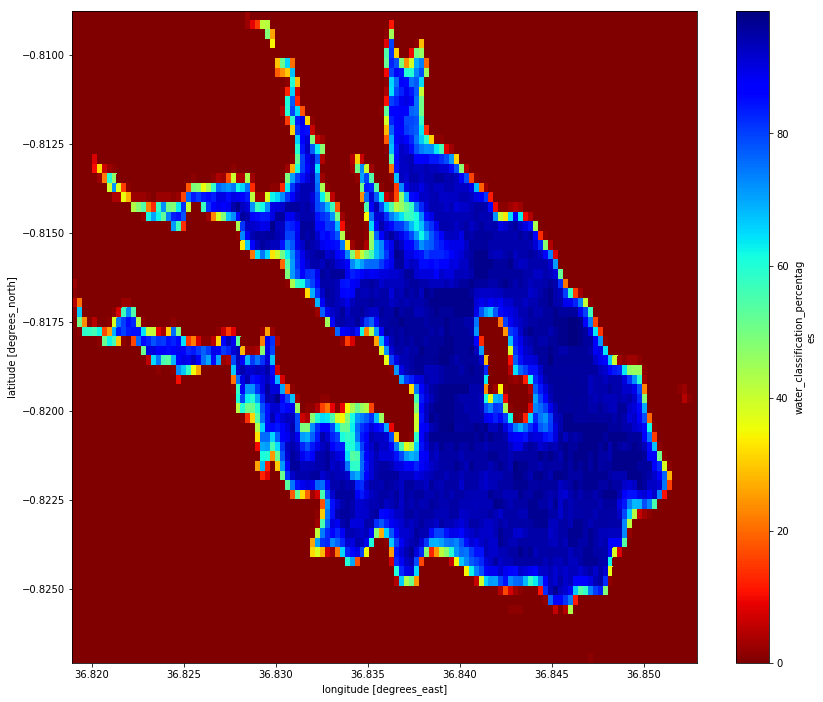

In [16]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

# The "figsize" may need adjustment to get the proper scaling and avoid distortion. 
# See the XARRAY dimensions above to get an idea of the Lat-Lon ratio for your image, figsize=(x,y)
# The y-axis scale and legend is part of the image area, so that needs to be considered
# It is suggested to keep the x-dimension at x=12. 

water_classification_percentages.plot(cmap = jet_r, figsize=(14,12))

The following code computes and then plots the percentage of valid pixels that were identified as water, for each time step in the time series. It should be noted that clouds can impact the statistical results by reducing the number of valid pixels.

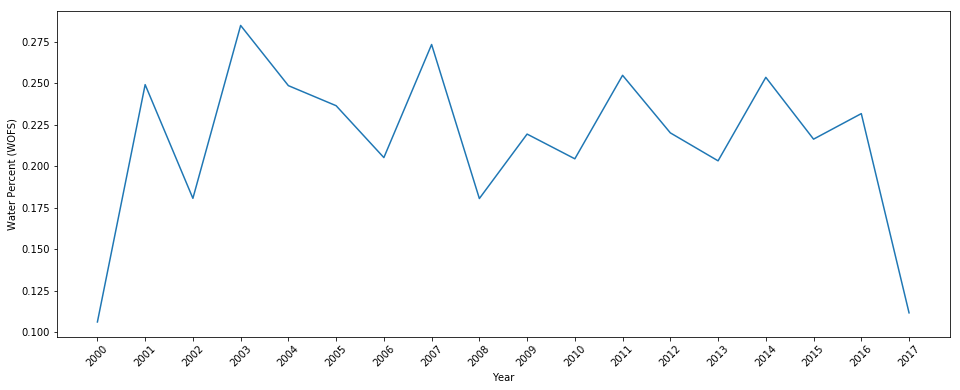

In [17]:
fig = plt.figure(figsize=(16,6))

pct_water_per_acq = ts_water_classification.wofs.mean(['latitude', 'longitude'])
pct_water_per_year = pct_water_per_acq.groupby('time.year').mean()
plt.plot(pct_water_per_year.values)
plt.xticks(range(len(pct_water_per_year)), pct_water_per_year.year.values, rotation=45)
plt.xlabel("Year")
plt.ylabel("Water Percent (WOFS)")
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [18]:
# Save the water percentage image to a GeoTIFF
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

dataset_to_export = xr.Dataset(coords=water_classification_percentages.coords,attrs=ts_water_classification.attrs)
dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)

<p style="color:red";><b>CHANGE INPUTS BELOW

In [19]:
# The export command on the following line is commented out to avoid overwriting files. 
# If you would like to export data, please change the filename before uncommenting the next line.

export_slice_to_geotiff(dataset_to_export, '../geotiffs/WOFS_Percentage_demo2.tif')

In [20]:
!ls -lah ../geotiffs/

total 1.1G
drwxrwxr-x  3 localuser localuser 4.0K May 10 21:13 .
drwxrwxrwx 14 root      root       12K May 10 20:41 ..
drwxrwxr-x  2 localuser localuser 4.0K Nov 30 02:52 .ipynb_checkpoints
-rw-rw-r--  1 localuser localuser  42M May 10 20:50 DEMO_median_composite.tif
-rw-rw-r--  1 localuser localuser 833M Apr 14 23:52 WOFS_Percentage_L-BIG_AC.tif
-rw-rw-r--  1 localuser localuser 123M Apr 11 12:36 WOFS_Percentage_L-Turkana_AC.tif
-rw-rw-r--  1 localuser localuser  53M Apr 11 10:09 WOFS_Percentage_L-Victoria_AC.tif
-rw-rw-r--  1 localuser localuser  34K Dec 19 20:38 WOFS_Percentage_demo.tif
-rw-rw-r--  1 localuser localuser  34K May 10 21:13 WOFS_Percentage_demo2.tif
-rw-rw-r--  1 localuser localuser 4.2M Dec 22 22:33 evi.tif
-rw-rw-r--  1 localuser localuser  17M May  6 18:20 frac_classes.tif
-rw-rw-r--  1 localuser localuser 4.2M Dec 22 22:33 ndvi_land.tif
-rw-rw-r--  1 localuser localuser 4.2M Dec 22 22:33 ndvi_land_and_water.tif
-rw-rw-r--  1 localuser localuser 4.7M May 10 21:10 s